In [ ]:
# Import necessary libraries
import math
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.modeling import models, fitting
from astropy.visualization import ZScaleInterval
from photutils.detection import DAOStarFinder, find_peaks
from photutils.aperture import CircularAperture, CircularAnnulus, CircularAnnulus, ApertureStats, aperture_photometry
from acstools import acszpt
from stdpipe import plots
from astroquery.vizier import Vizier
from astroquery.gaia import Gaia
from matplotlib.colors import LogNorm

In [ ]:
plt.rc('image', origin='lower', cmap='gray')

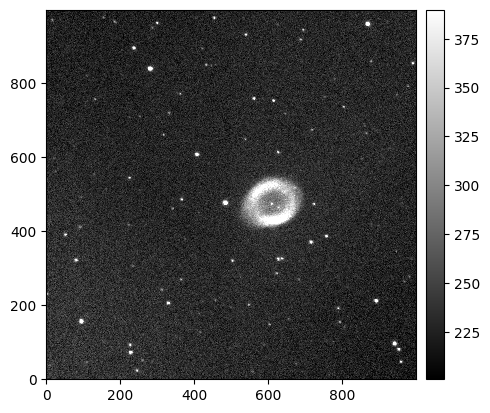

In [ ]:
# Open FITS file
fits_file = fits.open('/content/drive/MyDrive/M57/V_20240419_0054.fits')
image_data = fits_file[0].data

# Display the full image
plt.figure()
plots.imshow(image_data, [0.5, 99.7], interpolation='nearest')
plt.show()

In [ ]:
image_header = fits_file[0].header
image_header

SIMPLE  =                    T / Standard FITS file                             
BITPIX  =                  -32 / ASCII or bytes array                           
NAXIS   =                    2 / Minimal header                                 
NAXIS1  =                 1000                                                  
NAXIS2  =                 1000                                                  
EXTEND  =                    T / There may be FITS ext                          
OBSERVER= 'CU Students'                                                         
NOTES   = ''                                                                    
DATE_OBS= '2024-04-20'         / Date of observation                            
UT      = '01:17:14.510772'    / Time of Observation                            
EXPTIME = '60.0    '           / Exposure time in seconds                       
CCD_TEMP= '-119.7  '           / Camera temperature                             
FOCUS   = '146988  '        

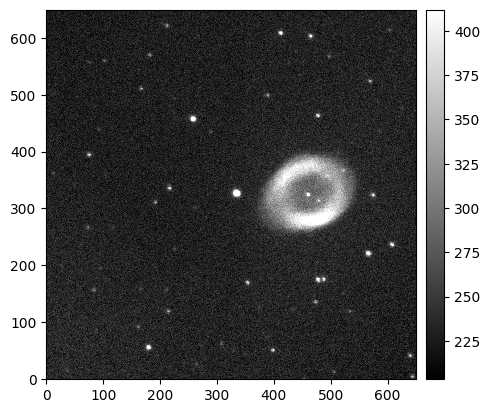

In [ ]:
# Define a section of the image
section1 = image_data[150:800, 150:800]

# Display the selected section
plt.figure()
plots.imshow(section1, [0.5, 99.7], interpolation='nearest')
plt.savefig('Section of Frame', format='png')
plt.show()

In [ ]:
# Calculate background statistics
mean, median, std = sigma_clipped_stats(section1, sigma=2.0)

# Detect stars
daofind = DAOStarFinder(fwhm=2.0, threshold=5.0 * std)
sources = daofind(section1 - median)
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag
int64,float64,float64,float64,float32,float64,int64,float32,float32,float32,float32
1,643.9093780099182,3.5617934885218263,0.6022503488481903,-0.079900205,0.3586163021121885,25,145.13857,2120.199,-8.315942,-0.532455
2,640.050231440397,40.65409798464856,0.43633350407368143,-0.0014188008,0.0845958537916976,25,190.66801,2801.9578,-8.618654,-1.0275536
3,398.6093129530919,50.30222780502113,0.6516520940443231,-0.011809431,0.15934438861517938,25,174.27696,2510.0647,-8.499212,-0.6566652
4,180.63888573495828,54.998501172018415,0.597685749569794,-0.041313615,-0.05944739301816474,25,455.31464,6657.344,-9.558252,-1.8064141
5,162.7068476642975,90.84157189024236,0.4762884575360263,-0.7861029,-0.29972647741241887,25,88.857285,1348.3405,-7.824499,-0.24952596
6,215.31565311449253,118.58278667045177,0.5614677708589438,-0.40513852,-0.15012458050042166,25,115.79259,1724.2135,-8.091477,-0.38447943
7,473.7065064780917,134.75344373570553,0.46028754684347073,-0.63548833,-0.04983411439218153,25,137.64467,2192.2207,-8.352211,-0.6122687
8,84.46262047872031,155.25108940911412,0.39468679567298415,-0.069439426,-0.44481780625304096,25,78.49089,1214.3754,-7.710882,-0.13400565
9,353.91834904237277,168.7442710129237,0.4601523905138279,-0.23760962,-0.5123695387327856,25,198.33186,3102.2278,-8.729184,-0.9663632


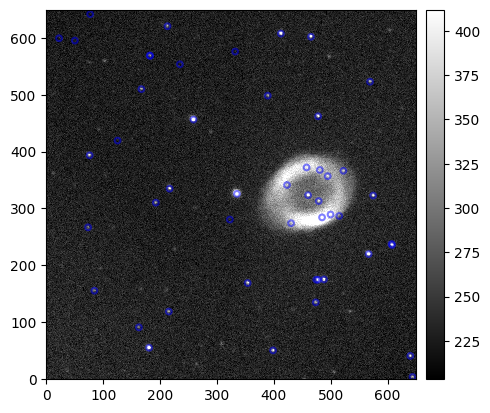

In [ ]:
# Display detected stars
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=5.0)
plt.figure()
plots.imshow(section1, [0.5, 99.7], interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)
plt.savefig('Detected Stars' , format='png')
plt.show()

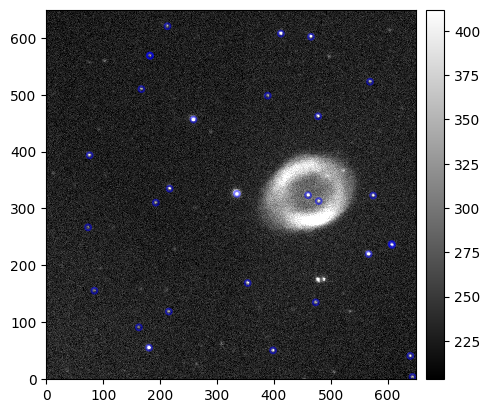

In [ ]:
# Create a mask to exclude bright regions

mask = np.zeros(section1.shape, dtype=bool)
mask[500:700, 0:100] = True
mask[500:600, 200:360] = True
mask[400:450, 100:200] = True
mask[200:290, 300:550] = True
mask[330:400, 400:600] = True
mask[140:200, 400:500] = True
#mask[308:314, 477:489]= True
# Re-detect stars with the mask applied
sources = daofind(section1 - median, mask=mask)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=5.0)

# Display the updated detection
plt.figure()
plots.imshow(section1, [0.5, 99.7], interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)
plt.savefig('Stars Detected with Mask', format='png')
plt.show()

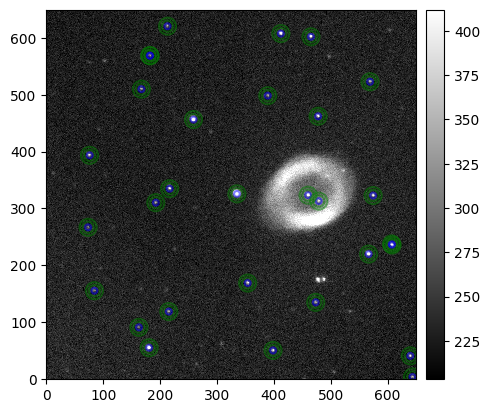

In [ ]:
# Define annuli for background measurement
annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)
aperstats = ApertureStats(section1, annulus_aperture)

# Plot the annuli
plt.figure()
plots.imshow(section1, [0.5, 99.7], interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)
annulus_aperture.plot(color='green', lw=1.5, alpha=0.5)
plt.savefig('Annual Background', format='png')
plt.show()

# Calculate background
bkg_mean = aperstats.mean
aperture_area = apertures.area_overlap(section1)
total_bkg = bkg_mean * aperture_area


In [ ]:
# Perform aperture photometry
star_data = aperture_photometry(section1, apertures)

# Add background data to the photometry table
star_data['total_bkg'] = total_bkg

# Display the photometry table
for col in star_data.colnames:
    star_data[col].info.format = '%.8g'
star_data.pprint()


 id  xcenter   ycenter  aperture_sum total_bkg
--- --------- --------- ------------ ---------
  1 643.90938 3.5617935    20671.238 16791.817
  2 640.05023 40.654098    22959.967 17894.603
  3 398.60931 50.302228    22588.515  18370.91
  4 180.63889 54.998501    30032.509 18527.123
  5 162.70685 90.841572    20554.663  18440.97
  6 215.31565 118.58279    21473.398 18359.703
  7 473.70651 134.75344    22016.383  18316.35
  8  84.46262 155.25109    20484.527 18394.471
  9 353.91835 168.74427    23874.749 18307.644
 10  566.7449 219.64633    32426.592 18511.431
...       ...       ...          ...       ...
 21 258.70581 456.30239     41413.84 18340.256
 22 477.89463 462.02328    24275.522  18281.58
 23 389.30944 498.23037    20631.269 18155.932
 24  167.1093 509.74814    20830.308 17981.914
 25 569.21301 522.72307    22041.208  18281.28
 26 182.56265 568.24864    20707.269 17881.364
 27 181.72648 569.01725    20738.191 17914.224
 28 465.28655 601.81815    25447.673 18235.174
 29 412.38266

In [ ]:
f = []
for line in star_data:
    flux = line['aperture_sum'] - line['total_bkg']
    f.append(flux)

f

[3879.420899047771,
 5065.3636646973355,
 4217.605199916841,
 11505.385528789873,
 2113.692488309098,
 3113.694889431088,
 3700.0337747855956,
 2090.055560236604,
 5567.105014345954,
 13915.160759902934,
 7867.8534110178625,
 7501.36562892664,
 2152.936060061762,
 2773.812011004098,
 1794.3237326242015,
 5182.515609591424,
 5690.341499542967,
 63897.05694730728,
 5543.167173798647,
 5426.680508947964,
 23073.58425486585,
 5993.942134789369,
 2475.3369195412924,
 2848.3944760957347,
 3759.9278456048814,
 2825.9049535170343,
 2823.967075723929,
 7212.498583630364,
 8061.892204377964,
 3175.8884695730812]

In [ ]:
GAIN = 2.14  # Example value, in electrons/ADU
RON = 3.92

# Perform aperture photometry
star_data = aperture_photometry(section1, apertures)

# Calculate total background per star
bkg_mean = aperstats.mean
aperture_area = apertures.area_overlap(section1)
total_bkg = bkg_mean * aperture_area

# Compute flux and flux uncertainty
flux = star_data['aperture_sum'] - total_bkg
photon_noise = np.sqrt(flux * GAIN)  # Photon noise (convert ADU to electrons)
background_noise = np.sqrt(aperture_area * (std ** 2))  # Background noise
readout_noise = RON * np.sqrt(aperture_area)  # Readout noise
flux_uncertainty = np.sqrt(photon_noise ** 2 + background_noise ** 2 + readout_noise ** 2)

# Add flux and flux uncertainty to the table
star_data['total_bkg'] = total_bkg
star_data['flux'] = flux
star_data['flux_uncertainty'] = flux_uncertainty

In [ ]:
# Calculate instrumental magnitudes and their uncertainties
extime = 60.0  # Exposure time from header
m_inst = []
m_inst_uncertainty = []

for line in star_data:
    flux_val = line['flux']
    flux_err = line['flux_uncertainty']

    # Compute magnitude
    mag = -2.5 * math.log10(flux_val / extime)
    m_inst.append(mag)

    # Compute magnitude uncertainty
    mag_err = (2.5 / np.log(10)) * (flux_err / flux_val)
    m_inst_uncertainty.append(mag_err)

# Add magnitudes and their uncertainties to the table
star_data['m_inst'] = m_inst
star_data['m_inst_uncertainty'] = m_inst_uncertainty

# Display the photometry table with errors
for col in star_data.colnames:
    star_data[col].info.format = '%.8g'
star_data.pprint(max_lines=-1, max_width=-1)

 id  xcenter   ycenter  aperture_sum total_bkg    flux   flux_uncertainty   m_inst   m_inst_uncertainty
--- --------- --------- ------------ --------- --------- ---------------- ---------- ------------------
  1 643.90938 3.5617935    20671.238 16791.817 3879.4209        123.45025 -4.5265391        0.034550106
  2 640.05023 40.654098    22959.967 17894.603 5065.3637        134.62178 -4.8161485        0.028855527
  3 398.60931 50.302228    22588.515  18370.91 4217.6052        127.70599 -4.6172867        0.032875296
  4 180.63889 54.998501    30032.509 18527.123 11505.386        178.61878 -5.7068748        0.016855835
  5 162.70685 90.841572    20554.663  18440.97 2113.6925        108.65747 -3.8672264        0.055813868
  6 215.31565 118.58279    21473.398 18359.703 3113.6949         118.0951  -4.287812        0.041179411
  7 473.70651 134.75344    22016.383  18316.35 3700.0338        123.29322 -4.4751361        0.036179104
  8  84.46262 155.25109    20484.527 18394.471 2090.0556        

In [ ]:
wcs = WCS(fits_file[0].header)

wcs

a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP' 'DEC--TAN-SIP' 
CRVAL : 283.398250505 33.0281563159 
CRPIX : 598.802947998 482.867233276 
CD1_1 CD1_2  : -0.000131448360842 5.73393406135e-06 
CD2_1 CD2_2  : -5.87418202726e-06 -0.000131518972612 
NAXIS : 1000  1000

In [ ]:
# Assuming `wcs` is already defined and aligned with your image
# Extract pixel coordinates from the table
xcenter = star_data['xcenter']
ycenter = star_data['ycenter']

# Convert pixel coordinates to RA and Dec
world_coords = wcs.pixel_to_world(xcenter, ycenter)

# Extract RA and Dec from the SkyCoord object
ra_deg = world_coords.ra.deg  # RA in degrees
dec_deg = world_coords.dec.deg  # Dec in degrees

# Add RA and Dec as new columns to the table
star_data['RA_deg'] = Column(ra_deg, name='RA_deg', format='%.8g')
star_data['Dec_deg'] = Column(dec_deg, name='Dec_deg', format='%.8g')

# Display the updated photometry table
star_data.write('ap_phot_V.csv', format='csv', overwrite=True)
star_data

id,xcenter,ycenter,aperture_sum,total_bkg,flux,flux_uncertainty,m_inst,m_inst_uncertainty,RA_deg,Dec_deg
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,643.90938,3.5617935,20671.238,16791.817,3879.4209,123.45025,-4.5265391,0.034550106,283.38781,33.090669
2,640.05023,40.654098,22959.967,17894.603,5065.3637,134.62178,-4.8161485,0.028855527,283.38866,33.085832
3,398.60931,50.302228,22588.515,18370.91,4217.6052,127.70599,-4.6172867,0.032875296,283.42661,33.08603
4,180.63889,54.998501,30032.509,18527.123,11505.386,178.61878,-5.7068748,0.016855835,283.46095,33.086702
5,162.70685,90.841572,20554.663,18440.97,2113.6925,108.65747,-3.8672264,0.055813868,283.46401,33.082097
6,215.31565,118.58279,21473.398,18359.703,3113.6949,118.0951,-4.287812,0.041179411,283.45591,33.078147
7,473.70651,134.75344,22016.383,18316.35,3700.0338,123.29322,-4.4751361,0.036179104,283.41538,33.074498
8,84.46262,155.25109,20484.527,18394.471,2090.0556,108.42446,-3.8550165,0.056324035,283.47678,33.074082
9,353.91835,168.74427,23874.749,18307.644,5567.105,138.55234,-4.9186954,0.027021457,283.43443,33.070746


In [ ]:
# Define the center of your frame and its search radius
center_ra = wcs.wcs.crval[0]  # RA (degrees)
center_dec = wcs.wcs.crval[1]  # Dec (degrees)
radius = 6 * u.arcmin  # Search radius around your frame

# Query APASS catalog
Vizier.ROW_LIMIT = -1  # Remove row limit
result = Vizier.query_region(
    SkyCoord(ra=center_ra, dec=center_dec, unit=(u.deg, u.deg)),
    radius=radius, catalog="APASS"
)

# Access the APASS catalog data
if result:
    apass_data = result[0]  # Table of APASS stars
    print(apass_data[['RAJ2000', 'DEJ2000', 'Vmag', 'e_Vmag']])
else:
    print("No stars found in the APASS catalog.")

apass_data.write('apass_V.csv', format='csv', overwrite=True)

 RAJ2000    DEJ2000    Vmag  e_Vmag
   deg        deg      mag    mag  
---------- ---------- ------ ------
283.359067  32.963835 13.375  0.000
283.454720  32.952026 13.070  0.000
283.504585  33.003021 14.107  0.000
283.405083  32.936383 11.168  0.000
283.450407  32.982886 13.420  0.000
283.415868  33.029584 13.072  0.000
283.428980  33.012718 14.187  0.000
283.321991  32.972681 11.598  0.000
283.312733  33.000911 12.399  0.000
283.394297  33.033888     --     --
283.394407  33.033445 11.891  0.142
283.392529  33.096884 12.467  0.000
283.326840  33.046511 12.848  0.000
283.341302  33.077266 13.513  0.000
283.350332  33.061937 14.191  0.000
283.298401  33.053491 11.122  0.000
283.474730  33.073874 13.829  0.000
283.468585  33.101378 13.864  0.000


In [ ]:
# Define the center of your frame and its search radius
center_ra = wcs.wcs.crval[0]  # RA (degrees)
center_dec = wcs.wcs.crval[1]  # Dec (degrees)
radius = 6 * u.arcmin  # Search radius

# Construct the query
query = f"""
SELECT
    source_id, ra, dec, phot_g_mean_mag, bp_rp, phot_variable_flag, parallax, pmra, pmdec
FROM gaiadr3.gaia_source
WHERE CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', {center_ra}, {center_dec}, {radius.to(u.deg).value})
) = 1
"""

# Execute the query
job = Gaia.launch_job(query)
results = job.get_results()

# Display the results
print(results)

# Save the results to a CSV file
results.write("gaia_dr3_query_results.csv", format="csv", overwrite=True)


     source_id              ra         ...          pmra                pmdec        
                           deg         ...        mas / yr             mas / yr      
------------------- ------------------ ... --------------------- --------------------
2090482014576932480  283.4129213603692 ...                    --                   --
2090482014579705344  283.4084180993967 ...                    --                   --
2090483487750496512  283.4817925739744 ...   -2.6137159360111553   -4.110452617659155
2090483487750500480  283.4790830696696 ...    -3.229565398862424   -5.733116507646704
2090481327386704640 283.37209778527614 ...   -2.3928043290992123   -6.040201481794526
2090481327386706688 283.37124537540655 ...   -0.2749552532115199   -4.122752275331342
2090481327386707584  283.3738824345583 ...    -4.171222208382746   -6.350681566745298
2090481357446452864 283.37782705047766 ...    -3.481629158211891  -2.2521366412823305
2090481361741815040   283.380308663526 ...    -4.98588

In [ ]:
#Matching the two tables

In [ ]:
matched_table = Table.read('/content/drive/MyDrive/M57/Matched_table_V.csv', format='ascii')

matched_table

source_id,ra,dec,phot_g_mean_mag,bp_rp,phot_variable_flag,parallax,pmra,pmdec,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,Field,nobs,mobs,B-V,e_B-V,Vmag,e_Vmag,Bmag,e_Bmag,g'mag,e_g'mag,r'mag,e_r'mag,i'mag,e_i'mag,Separation_1,id,xcenter,ycenter,aperture_sum,total_bkg,flux,flux_uncertainty,m_inst,m_inst_uncertainty,RA_deg,Dec_deg,Separation
float64,float64,float64,float64,float64,str13,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,int64,float64,float64,float64,int64,float64,int64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2.09048359512957e+18,283.428933760148,33.0127757964898,13.9603204727173,0.879329681396484,NOT_AVAILABLE,1.34040045545845,2.94077231667424,-5.56349883006443,283.42898,33.012718,0.838,1.411,20121630,2,6,0.71,0.018,14.187,0,14.897,0.018,14.576,0,13.988,0,13.785,0,0.250552971997295,29,412.38266,607.42423,26333.163,18271.271,8061.8922,156.63842,-5.3207143,0.021095296,283.42822,33.0127,2.17189260970185
2.09048369820879e+18,283.416002898795,33.0296011743335,12.8798770904541,0.803355216979981,NOT_AVAILABLE,1.10864465818898,-7.26344183141778,2.81173580372882,283.415868,33.029584,0.411,0.612,20121630,3,13,0.634,0.008,13.072,0,13.707,0.008,13.409,0,12.908,0,12.724,0,0.41181930130384,22,477.89463,462.02328,24275.522,18281.58,5993.9421,141.81037,-4.9989032,0.025687377,283.41693,33.031467,7.27649294918441


In [ ]:
z_point = matched_table['Vmag']-matched_table['m_inst']

z_point_avg = sum(z_point)/len(z_point)

z_point_avg

18.78930875

In [ ]:
z_point = matched_table[0]['Vmag'] - matched_table[0]['m_inst']
z_point

19.5077143

In [ ]:
z_point = matched_table[1]['Vmag'] - matched_table[1]['m_inst']
z_point

18.0709032

In [ ]:
m_inst = star_data['m_inst']

Rmag_cal = m_inst + z_point_avg

star_data['Vmag_cal'] = Rmag_cal

In [ ]:
errors = []

i = 0
while i < len(star_data['m_inst_uncertainty']):
    error = matched_table[0]['e_Vmag'] + star_data[i]['m_inst_uncertainty']
    errors.append(error)
    i += 1

star_data['Vmag_cal_err'] = errors
star_data.write('ap_phot_V.csv', format='csv', overwrite=True)

star_data[10:20]

id,xcenter,ycenter,aperture_sum,total_bkg,flux,flux_uncertainty,m_inst,m_inst_uncertainty,RA_deg,Dec_deg,Vmag_cal,Vmag_cal_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
11,608.07856,235.58941,26244.377,18376.524,7867.8534,155.30728,-5.2942625,0.02143186,283.39497,33.060456,13.495046,0.021431860479487534
12,606.99239,237.53884,25843.96,18342.595,7501.3656,152.76147,-5.2424727,0.022110462,283.39515,33.060206,13.546836,0.022110462148463
13,73.37792,266.73749,20299.685,18146.749,2152.9361,109.04324,-3.8871997,0.05499104,283.47928,33.059479,14.902109,0.054991039908103494
14,192.46563,310.06779,20795.983,18022.171,2773.812,114.97436,-4.1623144,0.045003706,283.46079,33.053102,14.626994,0.04500370630790526
15,478.94911,312.8628,26045.993,24251.67,1794.3237,105.46562,-3.6893739,0.063816715,283.41575,33.051075,15.099935,0.06381671450025501
16,460.19893,323.21085,27878.662,22696.146,5182.5156,135.54973,-4.8409734,0.028397646,283.41876,33.049825,13.948335,0.028397646311698208
17,574.64198,322.6527,24198.753,18508.411,5690.3415,139.50081,-4.9424677,0.026617221,283.4008,33.049222,13.846841,0.02661722127022766
18,335.09653,325.59822,82815.731,18918.674,63897.057,379.50342,-7.568324,0.0064485068,283.43844,33.05024,11.220985,0.006448506769499098
19,216.71302,334.67126,23599.159,18055.992,5543.1672,138.36735,-4.9140168,0.027101914,283.45714,33.049726,13.875292,0.027101913601866874


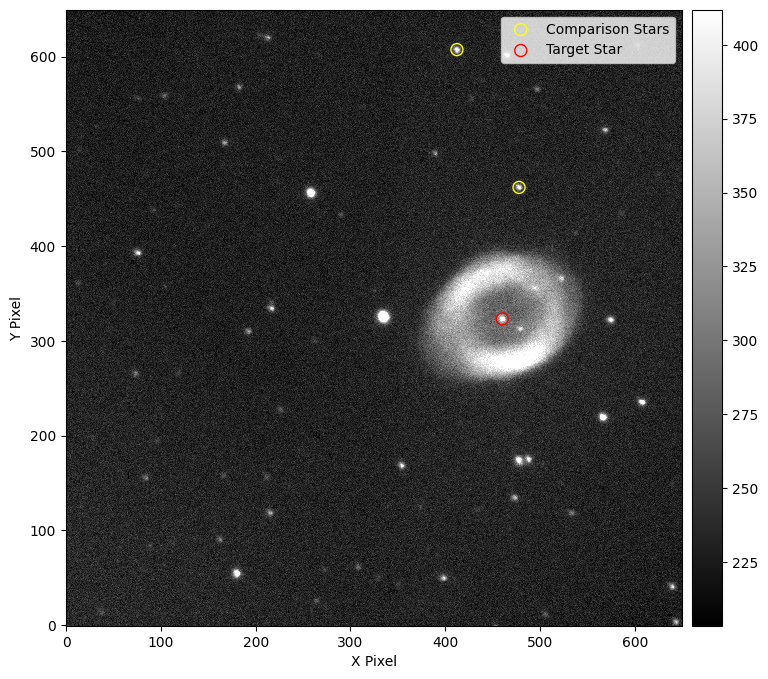

In [ ]:
# Load your FITS frame (replace 'your_frame.fits' with the actual file path)
fits_file = '/content/drive/MyDrive/M57/V_20240419_0054.fits'
frame_data = fits.getdata(fits_file)

# Extract matched stars' positions (xcenter, ycenter) from the table
comparison_x = matched_table['xcenter']
comparison_y = matched_table['ycenter']

target_x = 460.19893
target_y = 323.21085

# Visualize the frame with matched stars highlighted
plt.figure(figsize=(10, 8))
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(frame_data)  # Scale for better visualization
plots.imshow(section1, [0.5, 99.7], interpolation='nearest')
plt.scatter(comparison_x, comparison_y, s=75, facecolors='none', edgecolors='yellow', label='Comparison Stars')
plt.scatter(target_x, target_y, s=75, facecolors='none', edgecolors='red' , label='Target Star')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.legend()
plt.grid(False)
plt.savefig('Target and Comparison stars' , format='png')
plt.show()
